In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import cv2

In [3]:
SEED = 15243
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
tf.random.set_seed(SEED)
plt.rc("axes.spines", right=False, top=False)
plt.rc("font", family="serif")

In [4]:
BATCH_SIZE = 25
DATA_DIR = ("/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets")
 
IMG_SIZE = 256
MAX_EPOCHS = 500
class_names = ["lung_n", "lung_aca", "lung_scc"]
class_details = ["No Cancer", "Adenocarcinoma", "Squamous Cell Carcinoma"]

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    class_names=class_names,
    seed=45,
    subset="training",
    validation_split=0.2
)

Found 15000 files belonging to 3 classes.
Using 12000 files for training.


In [6]:
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    class_names=class_names,
    seed=45,
    subset="validation", 
    validation_split=0.2
)

Found 15000 files belonging to 3 classes.
Using 3000 files for validation.


In [ ]:
plt.figure(figsize=(14, 7))
for images, labels in train_ds.take(1):
    labels = labels.numpy()
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_details[labels[i]])
        plt.axis("off")

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache(".cached-data").prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)
def compile_and_fit_model(model: tf.keras.Sequential) -> tf.keras.callbacks.History:
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=1e-4,
        patience=5,
        mode="auto",
        restore_best_weights=True
    )
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.2,
        patience=5,
        min_lr=0.001
    )
    history = model.fit(
        train_ds,
        validation_data=validation_ds,
        epochs=MAX_EPOCHS,
        steps_per_epoch=50,
        callbacks=[early_stopping, reduce_lr]
    )
    performance_df = pd.DataFrame(history.history)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    for ax, metric in zip(axes.flat, ["accuracy", "loss"]):
        performance_df.filter(like=metric).plot(ax=ax)
        ax.set_title(metric.title(), size=15, pad=20)
    return history
def plot_predictions(model: tf.keras.Sequential) -> None:
    plt.figure(figsize=(14, 14))
    for images, labels in train_ds.take(1):
        labels = labels.numpy()
        predicted_labels = np.argmax(model.predict(images), axis=1)
        for i, (actual, pred) in enumerate(zip(predicted_labels, labels)):
            ax = plt.subplot(5, 5, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            if actual == pred:
                plt.title(class_details[labels[i]], color="green", size=9)
            else:
                plt.title(f"{class_details[predicted_labels[i]]}\n"
                          + f"(Actual: {class_details[labels[i]]})",
                          color="red", size=9)
            plt.axis("off")

In [9]:
pretrained_vgg16_base = tf.keras.applications.vgg16.VGG16(
    include_top=False, weights="imagenet", pooling="avg",
)
pretrained_vgg16_base.trainable = False

vgg16_model = tf.keras.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.Lambda(tf.keras.applications.vgg16.preprocess_input),
    pretrained_vgg16_base,
    layers.Dense(128, activation="relu"),
    layers.Dense(3, activation="softmax")
])
vgg16_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 512)            │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,739 (56.38 MB)

 Trainable params: 66,051 (258.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/500
 1/50 ━━━━━━━━━━━━━━━━━━━━ 28:47 35s/step - accuracy: 0.3200 - loss: 5.4478

I0000 00:00:1712136431.387772      94 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1712136431.408512      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.6904 - loss: 1.4927

W0000 00:00:1712136439.475424      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


50/50 ━━━━━━━━━━━━━━━━━━━━ 59s 478ms/step - accuracy: 0.6931 - loss: 1.4772 - val_accuracy: 0.9180 - val_loss: 0.2942 - learning_rate: 0.0010
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 448ms/step - accuracy: 0.9398 - loss: 0.1936 - val_accuracy: 0.9400 - val_loss: 0.1638 - learning_rate: 0.0010
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 453ms/step - accuracy: 0.9324 - loss: 0.2026 - val_accuracy: 0.9487 - val_loss: 0.1425 - learning_rate: 0.0010
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 456ms/step - accuracy: 0.9368 - loss: 0.1551 - val_accuracy: 0.9493 - val_loss: 0.1762 - learning_rate: 0.0010
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 462ms/step - accuracy: 0.9560 - loss: 0.1337 - val_accuracy: 0.9533 - val_loss: 0.1289 - learning_rate: 0.0010
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 467ms/step - accuracy: 0.9188 - loss: 0.1887 - val_accuracy: 0.9640 - val_loss: 0.1117 - learning_rate: 0.0010
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 468ms/step - accuracy: 0.9626 - loss: 0.0952 

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 421ms/step - accuracy: 0.9526 - loss: 0.1914 - val_accuracy: 0.9683 - val_loss: 0.0917 - learning_rate: 0.0010
Epoch 11/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 480ms/step - accuracy: 0.9757 - loss: 0.0842 - val_accuracy: 0.9587 - val_loss: 0.1048 - learning_rate: 0.0010
Epoch 12/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 482ms/step - accuracy: 0.9700 - loss: 0.0698 - val_accuracy: 0.9687 - val_loss: 0.0895 - learning_rate: 0.0010
Epoch 13/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 483ms/step - accuracy: 0.9670 - loss: 0.1006 - val_accuracy: 0.9547 - val_loss: 0.1196 - learning_rate: 0.0010
Epoch 14/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 483ms/step - accuracy: 0.9813 - loss: 0.0566 - val_accuracy: 0.9577 - val_loss: 0.1224 - learning_rate: 0.0010
Epoch 15/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 484ms/step - accuracy: 0.9702 - loss: 0.0907 - val_accuracy: 0.9567 - val_loss: 0.1427 - learning_rate: 0.0010
Epoch 16/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 486ms/step - accuracy: 0.9596 - loss: 0

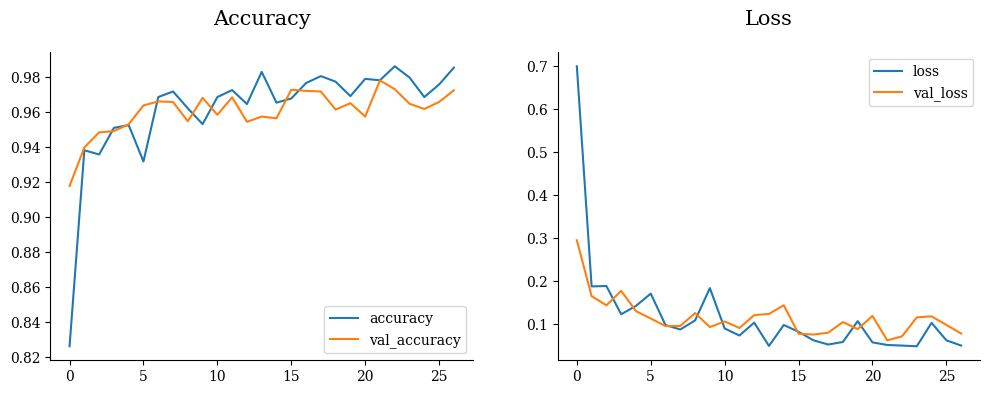

In [10]:
vgg16_history = compile_and_fit_model(vgg16_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step


W0000 00:00:1712137064.309034      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


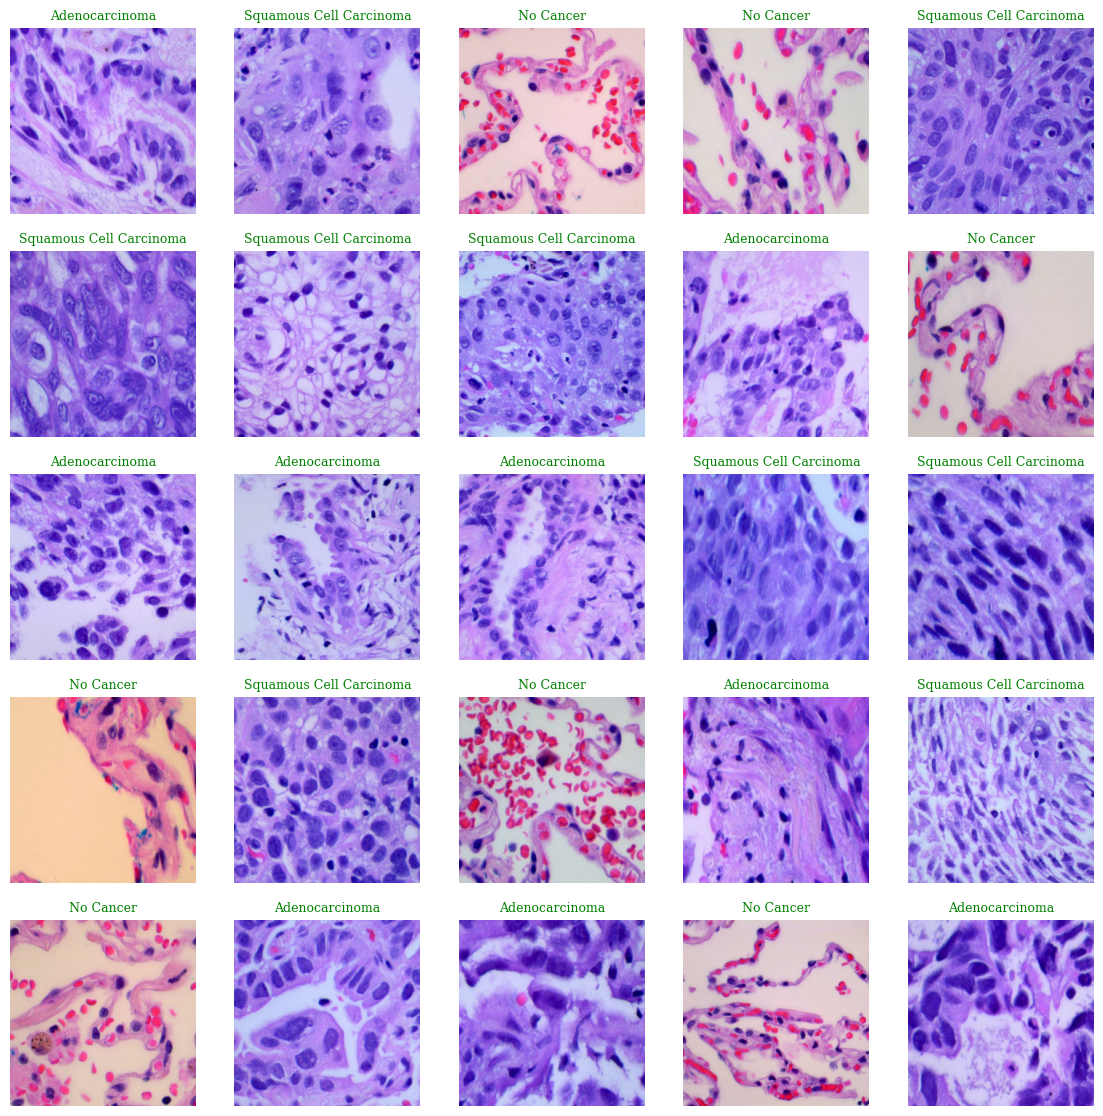

In [11]:
plot_predictions(vgg16_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━

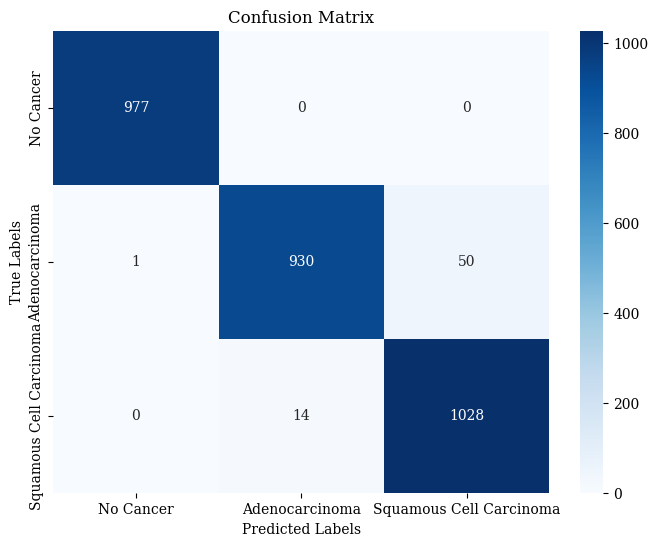

Classification Report:
                         precision    recall  f1-score   support

              No Cancer       1.00      1.00      1.00       977
         Adenocarcinoma       0.99      0.95      0.97       981
Squamous Cell Carcinoma       0.95      0.99      0.97      1042

               accuracy                           0.98      3000
              macro avg       0.98      0.98      0.98      3000
           weighted avg       0.98      0.98      0.98      3000



In [12]:
validation_predictions = []
validation_labels = []

for images, labels in validation_ds:
    validation_predictions.extend(np.argmax(vgg16_model.predict(images), axis=1))
    validation_labels.extend(labels.numpy())

conf_matrix = confusion_matrix(validation_labels, validation_predictions)

class_report = classification_report(validation_labels, validation_predictions, target_names=class_details)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_details, yticklabels=class_details)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:")
print(class_report)


lungaca10.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
[[1.5193028e-13 9.9999952e-01 4.8479865e-07]]


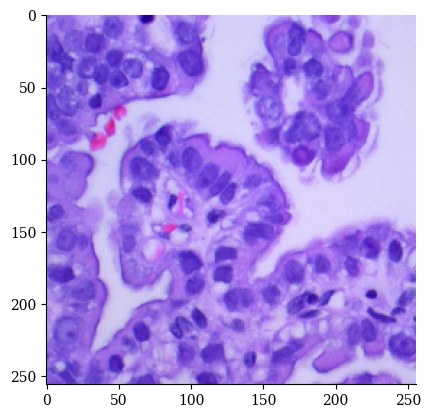

THE UPLOADED IMAGE IS SUSPECTED AS: adinocarcinoma
lungscc1007.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[[1.1557845e-15 4.6522220e-04 9.9953485e-01]]


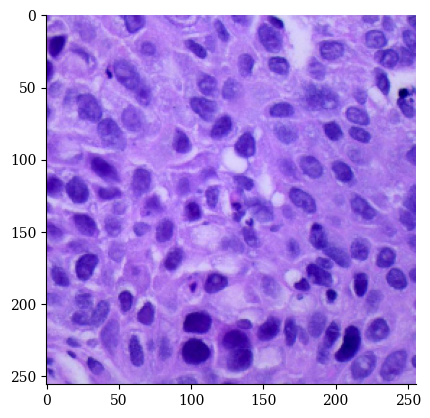

THE UPLOADED IMAGE IS SUSPECTED AS: squamous cell carcinoma
lungaca1013.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[[3.8296166e-09 9.9995959e-01 4.0380750e-05]]


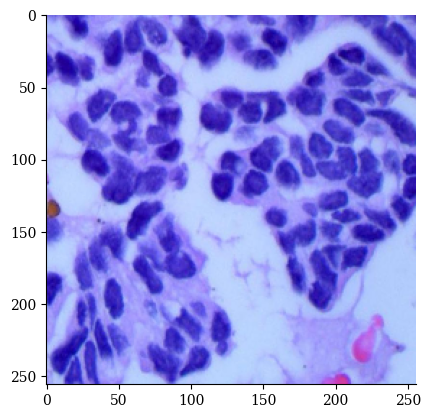

THE UPLOADED IMAGE IS SUSPECTED AS: adinocarcinoma
lungn1009.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[[1.000000e+00 3.300336e-09 8.408286e-14]]


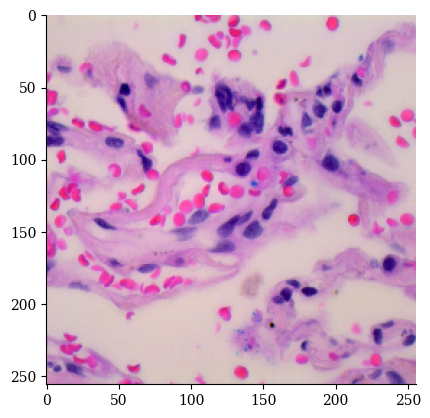

THE UPLOADED IMAGE IS SUSPECTED AS: no cancer 
lungn1011.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[[1.000000e+00 8.101650e-15 8.577497e-17]]


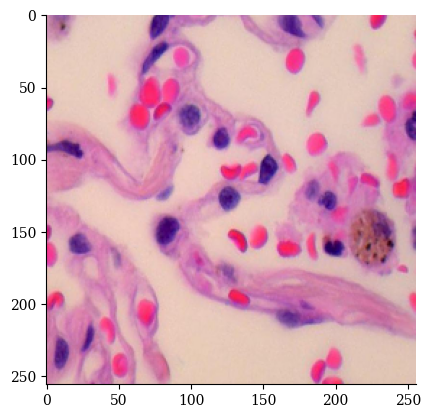

THE UPLOADED IMAGE IS SUSPECTED AS: no cancer 
lungaca1010.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[[1.4174996e-05 9.9079496e-01 9.1908621e-03]]


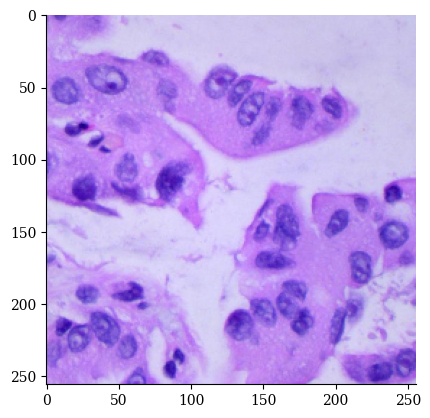

THE UPLOADED IMAGE IS SUSPECTED AS: adinocarcinoma
lungn1019.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[[1.0000000e+00 3.7477807e-10 3.4917246e-17]]


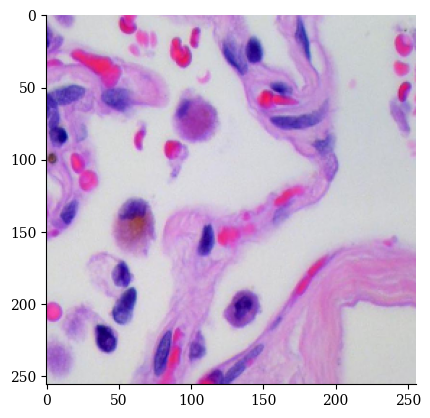

THE UPLOADED IMAGE IS SUSPECTED AS: no cancer 
lungscc100.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[[2.1670208e-09 1.8257418e-04 9.9981743e-01]]


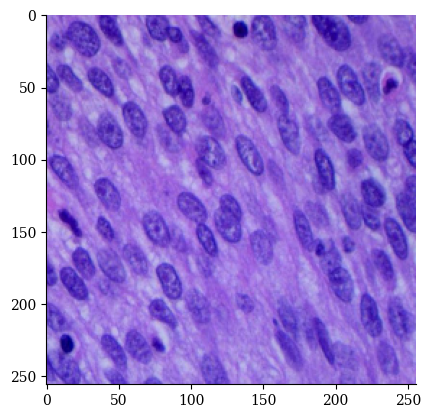

THE UPLOADED IMAGE IS SUSPECTED AS: squamous cell carcinoma
lungscc1010.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[[1.4677521e-13 4.5610227e-02 9.5438975e-01]]


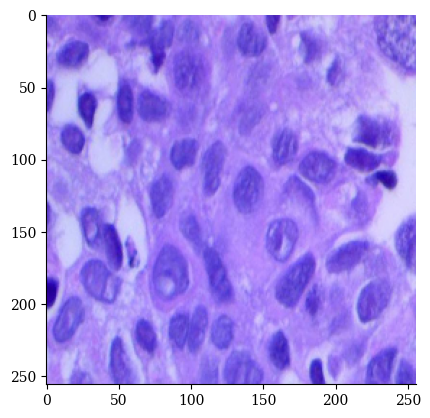

THE UPLOADED IMAGE IS SUSPECTED AS: squamous cell carcinoma
lungscc1.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[[5.566423e-10 9.819486e-05 9.999018e-01]]


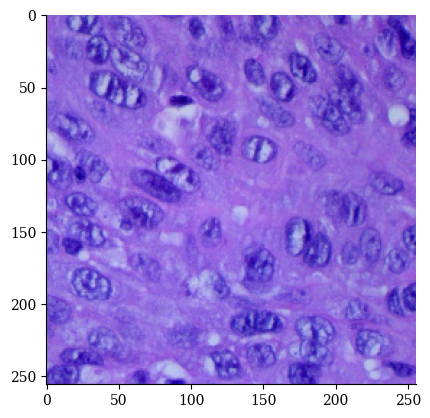

THE UPLOADED IMAGE IS SUSPECTED AS: squamous cell carcinoma
lungscc1005.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[[1.4949329e-12 2.8880290e-03 9.9711192e-01]]


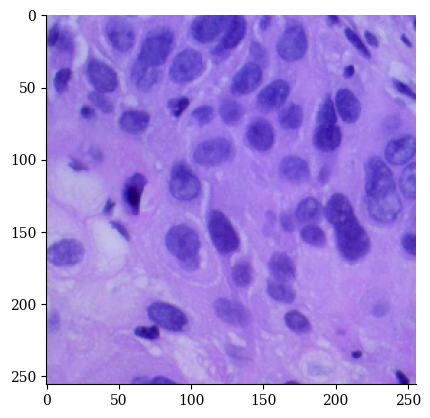

THE UPLOADED IMAGE IS SUSPECTED AS: squamous cell carcinoma
lungaca1.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[[5.5968799e-11 9.9999356e-01 6.4202745e-06]]


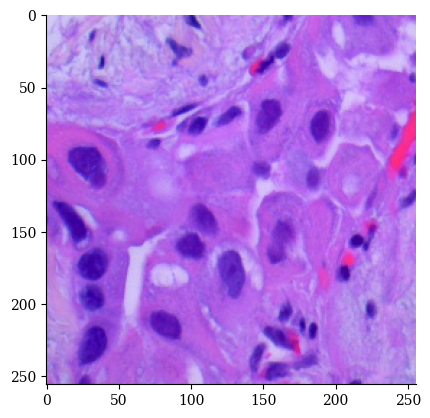

THE UPLOADED IMAGE IS SUSPECTED AS: adinocarcinoma
lungn1000.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[[1.0000000e+00 1.8345020e-08 3.3072906e-14]]


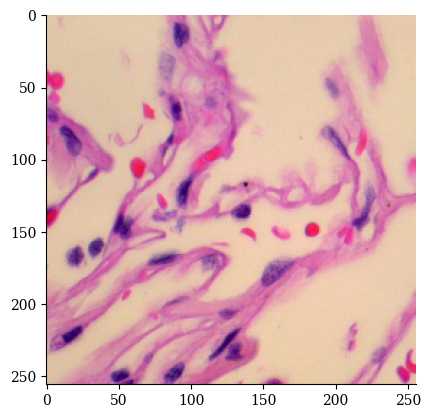

THE UPLOADED IMAGE IS SUSPECTED AS: no cancer 
lungn1.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[[9.999994e-01 6.018819e-07 4.081126e-12]]


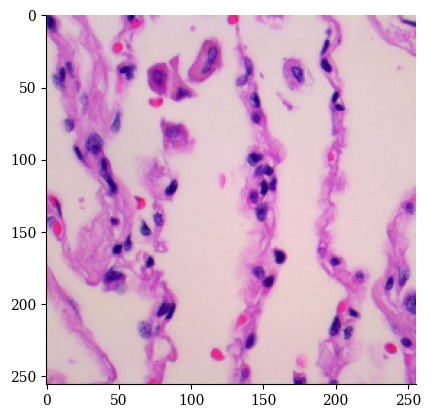

THE UPLOADED IMAGE IS SUSPECTED AS: no cancer 
lungaca1023.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[[2.0706487e-07 9.9992788e-01 7.1903916e-05]]


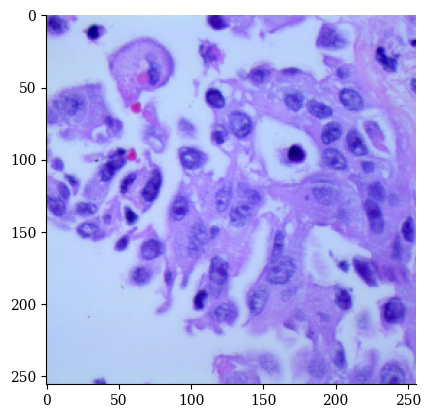

THE UPLOADED IMAGE IS SUSPECTED AS: adinocarcinoma


In [13]:
prediction_folder="/kaggle/input/prediction-set/pred"
image_files = os.listdir(prediction_folder)
from keras.preprocessing import image 
model=vgg16_model
for image_file in image_files:
    print(image_file)
    img = os.path.join(prediction_folder, image_file)
    img = image.load_img(img,target_size=(IMG_SIZE, IMG_SIZE))
    imag = image.img_to_array(img)
    imaga = np.expand_dims(imag,axis=0) 
    ypred = model.predict(imaga)
    print(ypred)
    a=np.argmax(ypred,-1)
    if a==0:
          op="no cancer "
    elif a==1:
          op="adinocarcinoma"
    else:
          op="squamous cell carcinoma"    
    plt.imshow(img)
    plt.show() 
    print("THE UPLOADED IMAGE IS SUSPECTED AS: "+str(op)) 